In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

import internal_ref as ref

import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf


from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import AdaBoostRegressor


In [35]:
CDC = ref.Home + '/df_final.csv'
labor = ref.Home + '/labor.csv'
hi = ref.Home + '/HI.csv'

df_CDC = pd.read_csv(CDC, dtype={'County Code' : int})
df_labor = pd.read_csv(labor, dtype={'series_id' : str, 
                                     'year' : int, 
                                     'period' : str, 
                                     'value' : object,
                                     'footnote_codes' : str,
                                     'area_code': str,
                                     'series_title' : str,
                                     'area_text' : str})
df_hi = pd.read_csv(hi)

/Users/allandong/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [36]:
df_CDC.drop(['Unnamed: 0', 'Unnamed: 0.1', 'Notes'], axis =1, inplace=True)

cdcColumns = ['County', 'County_Code', 'Race', 'Race_Code',
       'ICD_10_130_Infants',
       'ICD_10_130_Infants_Code', 'Cause_of_death',
       'Cause_of_death_Code', 'Gender', 'Gender_Code', 'Deaths', 'Births',
       'Death_Rate', 'Year']
df_CDC.columns = cdcColumns

In [37]:
df_labor_cty = df_labor[df_labor.area_code.str.find(r'CN') != -1]

In [38]:
df_labor_cty['FIPS'] = df_labor_cty['area_code'].map(lambda x: int(x[2:7]))
df_labor_cty_yr = df_labor_cty[df_labor_cty.period == 'M13']

/Users/allandong/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [39]:
df_labor_HI = pd.merge(df_labor_cty_yr, df_hi, 
                       how='inner', 
                       left_on=['year', 'FIPS'], 
                       right_on=['Year', 'Id2'])

In [40]:
df = pd.merge(df_labor_HI, df_CDC,
             how='inner',
             left_on=['Year', 'FIPS'],
             right_on=['Year', 'County_Code'])

In [41]:
df.drop(['series_id', 'year', 'footnote_codes', 'area_code', 'series_title', 'area_text',
         'Id', 'Id2', 'Geography', 'County_Code'], axis=1, inplace=True)

In [42]:
df['Death_ratio']=df['Deaths']/df['Births']
df['HI_ratio'] = df['Est_1_HI_pop']/df['Est_total_pop']


In [43]:
df.unemployment_rate = df.unemployment_rate.apply(pd.to_numeric)

In [44]:
df1 = df.drop(['period', 'FIPS', 'Est_total_pop', 'Est_1_HI_pop',
       'Est_0_HI_pop', 'Race_Code',
       'ICD_10_130_Infants_Code', 
       'Cause_of_death_Code', 'Gender_Code', 'Deaths', 'Births',
       'Death_Rate'], axis=1)

In [45]:
df1.head()

,unemployment_rate,Year,HI_ratio,County,Race,ICD_10_130_Infants,Cause_of_death,Gender,Death_ratio
0,5.4,2008,0.112824,"Maricopa County, AZ",White,Certain conditions originating in the perinata...,Extreme immaturity,Female,0.000522
1,5.4,2008,0.112824,"Maricopa County, AZ",White,Certain conditions originating in the perinata...,Extreme immaturity,Male,0.000395
2,5.4,2008,0.112824,"Maricopa County, AZ",White,Disorders related to length of gestation and f...,Extreme immaturity,Female,0.000522
3,5.4,2008,0.112824,"Maricopa County, AZ",White,Disorders related to length of gestation and f...,Extreme immaturity,Male,0.000395
4,5.4,2008,0.112824,"Maricopa County, AZ",White,#Disorders related to short gestation and low ...,Extreme immaturity,Female,0.000522


# Initial Regression

In [46]:
df_county = patsy.dmatrix('County', data=df1, return_type='dataframe').drop('Intercept', 1)
df_race = patsy.dmatrix('Race', data=df1, return_type='dataframe').drop('Intercept', 1)
df_icd = patsy.dmatrix('ICD_10_130_Infants', data=df1, return_type='dataframe').drop('Intercept', 1)
df_cause = patsy.dmatrix('Cause_of_death', data=df1, return_type='dataframe').drop('Intercept', 1)
df_gender = patsy.dmatrix('Gender', data=df1, return_type='dataframe').drop('Intercept', 1)
df_year = patsy.dmatrix('Year', data=df1, return_type='dataframe').drop('Intercept', 1)

In [47]:
df_lr = df1.drop(['County','Race','ICD_10_130_Infants', 'Cause_of_death','Gender'], axis=1)

In [48]:
df_lr1 = pd.concat([df_lr,
                    df_year,
                   df_county,
                   df_race,
                   df_icd,
                   df_cause,
                   df_gender
                   ], axis=1, join='inner')

In [49]:
test

unemployment_rate  \
Year County                     Race                      Gender                      
2008 Baltimore city, MD         Black or African American Female                6.5   
                                                          Male                  6.5   
     Bexar County, TX           White                     Male                  4.6   
     Caddo Parish, LA           Black or African American Female                5.7   
     Cook County, IL            Black or African American Female                6.4   
                                                          Male                  6.4   
                                White                     Female                6.4   
                                                          Male                  6.4   
     Cuyahoga County, OH        Black or African American Female                6.2   
                                                          Male                  6.2   
     Dallas County, TX          Black or African American Male                  5.3   
                                White                     Female                5.3   
                                                          Male                  5.3   
     Duval County, FL           Black or African American Female                6.4   
     Fulton County, GA          Black or African American Male                  6.4   
     Harris County, TX          Black or African American Female                4.7   
                                                          Male                  4.7   
                                White                     Female                4.7   
                                                          Male                  4.7   
     Kings County, NY           Black or African American Female                6.0   
                                                          Male                  6.0   
     Los Angeles County, CA     Black or African American Male                  7.6   
                                White                     Female                7.6   
                                                          Male                  7.6   
     Maricopa County, AZ        White                     Female                5.4   
                                                          Male                  5.4   
     Philadelphia County, PA    Black or African American Female                7.1   
                                                          Male                  7.1   
                                White                     Male                  7.1   
     Prince George's County, MD Black or African American Male                  4.3   
...                                                                             ...   
2014 Baltimore city, MD         Black or African American Male                  8.5   
     Bexar County, TX           White                     Male                  4.7   
     Broward County, FL         Black or African American Female                5.9   
     Cook County, IL            Black or African American Female                7.5   
                                                          Male                  7.5   
                                White                     Female                7.5   
                                                          Male                  7.5   
     Cuyahoga County, OH        Black or African American Male                  6.3   
     Dallas County, TX          Black or African American Male                  5.4   
                                White                     Male                  5.4   
     Franklin County, OH        Black or African American Female                4.9   
                                                          Male                  4.9   
     Hamilton County, OH        Black or African American Male                  5.5   
     Harris County, TX          Black or African American Male  

In [50]:
test = df1.groupby(['Year','County', 'Race', 'Gender']).first()
new_df = pd.DataFrame(test).reset_index()

In [51]:
new_df_county = patsy.dmatrix('County', data=new_df, return_type='dataframe').drop('Intercept', 1)
new_df_race = patsy.dmatrix('Race', data=new_df, return_type='dataframe').drop('Intercept', 1)
new_df_icd = patsy.dmatrix('ICD_10_130_Infants', data=new_df, return_type='dataframe').drop('Intercept', 1)
new_df_cause = patsy.dmatrix('Cause_of_death', data=new_df, return_type='dataframe').drop('Intercept', 1)
new_df_gender = patsy.dmatrix('Gender', data=new_df, return_type='dataframe').drop('Intercept', 1)
new_df_year = patsy.dmatrix('Year', data=new_df, return_type='dataframe').drop('Intercept', 1)

In [52]:
new_df.drop(['Year', 'County','Race','Gender', 'ICD_10_130_Infants', 'Cause_of_death'], axis=1, inplace=True)

In [53]:
new_df1= pd.concat([new_df,
                    new_df_year,
                   new_df_county,
                   #new_df_icd,
                   new_df_race,
                   new_df_gender
                   ], axis=1, join='inner')

In [54]:
new_x = new_df1.drop('Death_ratio', axis=1).astype('float')
new_x['intercept'] = np.ones(len(new_x))
new_y = new_df1.Death_ratio

x_train_new, x_test_new, y_train_new, y_test_new = train_test_split(new_x, new_y, 
                                                                    test_size = 0.25, random_state=20)

In [55]:
new_model = sm.OLS(y_train_new, x_train_new)
new_fit = new_model.fit()
new_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Death_ratio   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     34.35
Date:                Wed, 13 Sep 2017   Prob (F-statistic):           8.09e-52
Time:                        13:30:46   Log-Likelihood:                 1026.4
No. Observations:                 170   AIC:                            -1967.
Df Residuals:                     127   BIC:                            -1832.
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
unemployment_rate                     -2.728e-05   5.33e-05     -0.512      0.610      -0.000    7.82e-05
HI_ratio                                 -0.0040      0.007     -0.565      0.573      -0.018       0.010
Year                                  -4.794e-05   4.11e-05     -1.167      0.245      -0.000    3.33e-05
County[T.Baltimore city, MD]              0.0008      0.001      1.066      0.288      -0.001       0.002
County[T.Bexar County, TX]               -0.0014      0.001     -1.800      0.074      -0.003       0.000
County[T.Bronx County, NY]               -0.0004      0.001     -0.473      0.637      -0.002       0.001
County[T.Broward County, FL]             -0.0010      0.001     -1.041      0.300      -0.003       0.001
County[T.Caddo Parish, LA]                0.0071      0.001      9.217      0.000       0.006       0.009
County[T.Clark County, NV]             4.647e-16   4.11e-16      1.129      0.261    -3.5e-16    1.28e-15
County[T.Cook County, IL]                -0.0009      0.001     -1.275      0.205      -0.002       0.001
County[T.Cuyahoga County, OH]             0.0005      0.001      0.615      0.540      -0.001       0.002
County[T.Dallas County, TX]              -0.0007      0.001     -0.860      0.391      -0.002       0.001
County[T.District of Columbia, DC]        0.0001      0.001      0.127      0.899      -0.002       0.002
County[T.Duval County, FL]            -2.676e-17   8.56e-17     -0.313      0.755   -1.96e-16    1.43e-16
County[T.East Baton Rouge Parish, LA]     0.0033      0.001      3.265      0.001       0.001       0.005
County[T.Essex County, NJ]            -8.506e-16   6.59e-16     -1.290      0.199   -2.16e-15    4.54e-16
County[T.Franklin County, OH]             0.0003      0.001      0.327      0.744      -0.002       0.002
County[T.Fresno County, CA]              4.2e-05      0.001      0.042      0.966      -0.002       0.002
County[T.Fulton County, GA]              -0.0004      0.001     -0.380      0.704      -0.002       0.002
County[T.Hamilton County, OH]             0.0018      0.001      1.822      0.071      -0.000       0.004
County[T.Harris County, TX]              -0.0015      0.001     -1.998      0.048      -0.003   -1.46e-05
County[T.Hillsborough County, FL]        -0.0004      0.001     -0.465      0.643      -0.002       0.001
County[T.Jefferson County, AL]            0.0030      0.001      3.136      0.002       0.001       0.005
County[T.Kern County, CA]                -0.0005      0.001     -0.487      0.627      -0.002       0.001
County[T.King County, WA]              5.566e-16   3.48e-16      1.598      0.112   -1.32e-16    1.25e-15
County[T.Kings County, NY]               -0.0020      0.001     -2.369      0.019      -0.004      -0.000
County[T.

In [56]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.naive_bayes import GaussianNB

In [57]:
lr = LinearRegression()
lr.fit(x_train_new, y_train_new)
lrpredict = lr.predict(x_test_new)


In [58]:
lr.score(x_train_new, y_train_new)

0.91909460761032069

In [59]:
lr.score(x_test_new, y_test_new)

0.78669924637161359

In [60]:
ridge = Ridge()
ridge.fit(x_train_new, y_train_new)
ridgepredict = ridge.predict(x_test_new)

In [61]:
ridge.score(x_train_new, y_train_new)

0.87374994010663687

In [62]:
ridge.score(x_test_new, y_test_new)

0.79960619449445758

In [63]:
lasso = Lasso()
lasso.fit(x_train_new, y_train_new)
lassopredict = lasso.predict(x_test_new)

In [64]:
lasso.score(x_train_new, y_train_new)

0.0

In [65]:
lasso.score(x_test_new, y_test_new)

-0.0037065366925406185

# Standard Scaling

In [67]:
# Create new x,y that has non-categorical variables standardized

x_newdf = new_df.drop('Death_ratio', axis=1)
y_newdf = new_df.Death_ratio

In [68]:
x_train_newdf, x_test_newdf, y_train_newdf, y_test_newdf = train_test_split(x_newdf, y_newdf, 
                                                                           test_size=0.25, random_state=20)

In [69]:
new_df2 = new_df1.drop(['unemployment_rate', 'HI_ratio', 'Death_ratio'], axis=1)

x_train_patsy, x_test_patsy = train_test_split(new_df2, test_size=0.25, random_state=20)


x_train_patsy.reset_index(inplace=True)
x_train_patsy.drop('index', axis=1, inplace=True)
x_test_patsy.reset_index(inplace=True)
x_test_patsy.drop('index', axis=1, inplace=True)


/Users/allandong/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/allandong/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [174]:
ss = StandardScaler()
ss.fit(x_train_newdf)

ss_x_newdf_train = ss.transform(x_train_newdf)
ss_x_newdf_test = ss.transform(x_test_newdf)

df_newdf_trainx_ss = pd.DataFrame(ss_x_newdf_train, columns=['unemployment_rate', 'HI_ratio'])
df_newdf_testx_ss = pd.DataFrame(ss_x_newdf_test, columns=['unemployment_rate', 'HI_ratio'])


df_newdf_trainx = pd.concat([df_newdf_trainx_ss, x_train_patsy], axis=1)
df_newdf_trainx['intercept'] = np.ones(len(df_newdf_trainx))

df_newdf_testx = pd.concat([df_newdf_testx_ss, x_test_patsy], axis=1)
df_newdf_testx['intercept'] = np.ones(len(df_newdf_testx))

In [178]:
# Linear Regression
lr = LinearRegression()
lr.fit(df_newdf_trainx, y_train_new)
lrpredict = lr.predict(x_test_new)


In [179]:
lr.score(df_newdf_trainx, y_train_new)

0.9190946076103208

In [175]:
# Ridge Regression
ridge = Ridge()
ridge.fit(df_newdf_trainx, y_train_newdf)
ridgepredict = ridge.predict(df_newdf_testx)

In [176]:
ridge.score(df_newdf_trainx, y_train_new)

0.87308926952631294

In [73]:
lasso = Lasso()
lasso.fit(df_newdf_trainx, y_train_newdf)
lassopredict = lasso.predict(df_newdf_testx)

In [74]:
lasso.score(df_newdf_trainx, y_train_newdf)

0.0

In [169]:
alphas=[1e-5,1e-3,1e-1,0,1,100, 1000]
all_scores=[]


for a in alphas:
    est=Lasso(alpha=a,fit_intercept=False)
    est.fit(df_newdf_trainx, y_train_newdf)
    mse=np.mean((y_test_newdf-est.predict(df_newdf_testx))**2)
    all_scores.append(mse)

    
all_scores

/Users/allandong/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  import sys
/Users/allandong/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/Users/allandong/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[6.256444920472025e-07,
 2.5766085101140765e-06,
 2.5886955009738173e-06,
 6.215773886838004e-07,
 2.9210088243737206e-06,
 8.54099367587453e-06,
 8.54099367587453e-06]

/Users/allandong/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


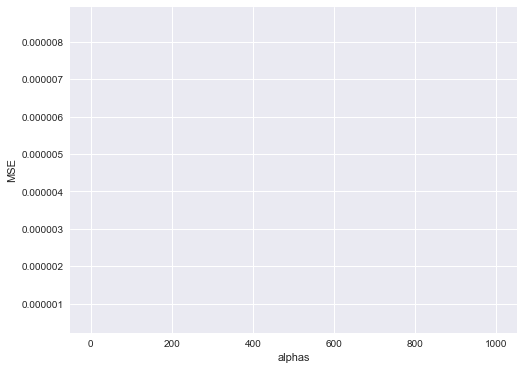

In [173]:
plt.figure(figsize=(8,6))
#plt.ylim(0,0.1)
plt.legend()
for i in range(7):
    plt.plot(alphas[i], all_scores[i])
plt.legend()
plt.xlabel('alphas')
plt.ylabel('MSE')
plt.show()

In [89]:
y_test_new1=y_test_new.reset_index().drop('index', axis=1)
y_test_new1=y_test_new.reset_index().drop('index', axis=1)

new_model = sm.OLS(y_test_new1, df_newdf_testx)
new_fit = new_model.fit()
new_fit.summary()


/Users/allandong/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:1036: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/Users/allandong/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/allandong/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/allandong/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Death_ratio   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     19.53
Date:                Wed, 13 Sep 2017   Prob (F-statistic):           8.39e-13
Time:                        14:20:14   Log-Likelihood:                 366.32
No. Observations:                  57   AIC:                            -680.6
Df Residuals:                      31   BIC:                            -627.5
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
unemployment_rate                        2.7e-05      0.000      0.161      0.873      -0.000       0.000
HI_ratio                               3.818e-05      0.000      0.179      0.859      -0.000       0.000
Year                                  -9.286e-05   7.29e-05     -1.275      0.212      -0.000    5.57e-05
County[T.Baltimore city, MD]              0.0109      0.006      1.716      0.096      -0.002       0.024
County[T.Bexar County, TX]                0.0083      0.007      1.215      0.233      -0.006       0.022
County[T.Bronx County, NY]            -4.998e-15   3.85e-15     -1.298      0.204   -1.29e-14    2.86e-15
County[T.Broward County, FL]              0.0080      0.007      1.184      0.246      -0.006       0.022
County[T.Caddo Parish, LA]            -2.239e-15   1.73e-15     -1.298      0.204   -5.76e-15    1.28e-15
County[T.Clark County, NV]                0.0082      0.007      1.212      0.235      -0.006       0.022
County[T.Cook County, IL]                 0.0080      0.007      1.207      0.237      -0.006       0.022
County[T.Cuyahoga County, OH]         -2.034e-15   1.57e-15     -1.297      0.204   -5.23e-15    1.17e-15
County[T.Dallas County, TX]               0.0088      0.007      1.279      0.210      -0.005       0.023
County[T.District of Columbia, DC]     2.941e-15   2.27e-15      1.297      0.204   -1.69e-15    7.57e-15
County[T.Duval County, FL]                0.0095      0.006      1.522      0.138      -0.003       0.022
County[T.East Baton Rouge Parish, LA]     0.0115      0.007      1.670      0.105      -0.003       0.026
County[T.Essex County, NJ]                0.0090      0.007      1.359      0.184      -0.004       0.022
County[T.Franklin County, OH]             0.0092      0.007      1.312      0.199      -0.005       0.024
County[T.Fresno County, CA]            5.664e-16   4.37e-16      1.296      0.205   -3.25e-16    1.46e-15
County[T.Fulton County, GA]           -9.864e-16   7.61e-16     -1.297      0.204   -2.54e-15    5.65e-16
County[T.Hamilton County, OH]          1.403e-15   1.08e-15      1.296      0.204   -8.05e-16    3.61e-15
County[T.Harris County, TX]               0.0077      0.007      1.107      0.277      -0.006       0.022
County[T.Hillsborough County, FL]      4.245e-17   3.26e-17      1.300      0.203   -2.41e-17    1.09e-16
County[T.Jefferson County, AL]         8.573e-17   6.64e-17      1.291      0.206   -4.97e-17    2.21e-16
County[T.Kern County, CA]              5.711e-17   4.41e-17      1.296      0.205   -3.28e-17    1.47e-16
County[T.King County, WA]                 0.0083      0.007      1.254      0.219      -0.005       0.022
County[T.Kings County, NY]                0.0067      0.007      1.022      0.314      -0.007       0.020
County[T.

In [91]:
pca = PCA(n_components=2)

x_train_std = ss.fit_transform(df_newdf_trainx)

x_test_std = ss.fit_transform(df_newdf_testx)

pca.fit(x_train_std)
x_pca_tsform = pca.transform(x_test_std)               

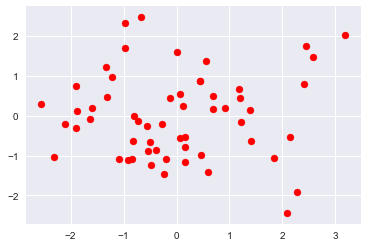

In [92]:
#plt.scatter(x_train_new)
plt.scatter(x_pca_tsform[:,0],x_pca_tsform[:,1], c='red')


In [93]:
pca_df=pd.DataFrame(pca.components_, columns=x_train_new.columns, index=['PCA-1', 'PCA-2']).T

In [94]:
pca_df['PCA-1'].reindex(pca_df['PCA-1'].abs().sort_values(inplace=False, ascending=False).index)

HI_ratio                                 4.288603e-01
Race[T.White]                           -4.177177e-01
unemployment_rate                        3.740989e-01
County[T.Harris County, TX]             -3.163527e-01
County[T.Philadelphia County, PA]        3.036212e-01
County[T.Wayne County, MI]               2.814845e-01
County[T.Dallas County, TX]             -2.473255e-01
Year                                     1.847053e-01
County[T.Baltimore city, MD]             1.709588e-01
County[T.Tarrant County, TX]            -1.307085e-01
Gender[T.Male]                           1.226842e-01
County[T.Bexar County, TX]              -9.328188e-02
County[T.San Diego County, CA]          -8.917493e-02
County[T.Shelby County, TN]              8.894918e-02
County[T.Will County, IL]               -8.678171e-02
County[T.Oklahoma County, OK]           -7.634989e-02
County[T.Milwaukee County, WI]           7.416549e-02
County[T.Caddo Parish, LA]               6.892000e-02
County[T.Jefferson County, A

In [95]:
pca_df['PCA-2'].reindex(pca_df['PCA-2'].abs().sort_values(inplace=False, ascending=False).index)

HI_ratio                                 0.507781
unemployment_rate                       -0.360775
Year                                     0.359450
County[T.Maricopa County, AZ]            0.341618
Race[T.White]                            0.271826
County[T.Wayne County, MI]              -0.208818
County[T.Queens County, NY]              0.183890
County[T.Hillsborough County, FL]        0.155691
County[T.Worcester County, MA]           0.152047
County[T.Philadelphia County, PA]        0.144770
County[T.Shelby County, TN]             -0.126839
County[T.Marion County, IN]             -0.117745
County[T.Cook County, IL]               -0.117317
County[T.Kings County, NY]              -0.103564
County[T.Bronx County, NY]              -0.100855
Gender[T.Male]                          -0.096324
County[T.Dallas County, TX]             -0.090858
County[T.District of Columbia, DC]      -0.084829
County[T.Bexar County, TX]               0.083993
County[T.Los Angeles County, CA]        -0.080521


# Tree

In [106]:
dt_test_sc = []
dt_train_sc = []

for n in range(1,21):
    DT_reg = DecisionTreeRegressor(max_depth=n)

    train = DT_reg.fit(x_train_new, y_train_new).score(x_train_new, y_train_new)
    dt_train_sc.append(train)
    
    test = DT_reg.fit(x_test_new, y_test_new).score(x_test_new, y_test_new)
    dt_test_sc.append(test)
    

/Users/allandong/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


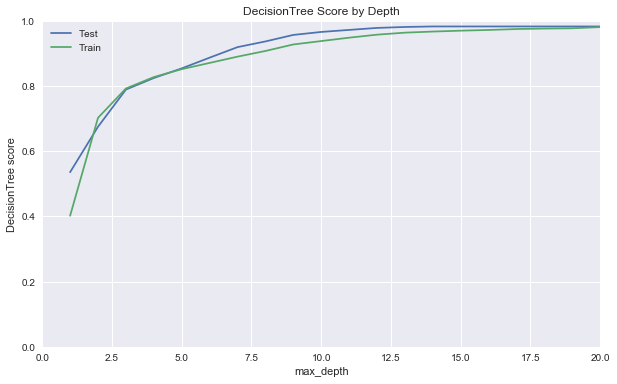

In [141]:
plt.figure(figsize=(10,6))
plt.ylim(0,1)
plt.xlim(0,20)
plt.legend()

plt.plot(range(1,21), dt_test_sc, label='Test')
plt.plot(range(1,21), dt_train_sc, label='Train')
plt.title('DecisionTree Score by Depth')
plt.legend()
plt.xlabel('max_depth')
plt.ylabel('DecisionTree score')
plt.show()

In [136]:
reg1 = DecisionTreeRegressor(max_depth=2)
reg2 = DecisionTreeRegressor(max_depth=10)

reg1.fit(x_train_new, y_train_new)
reg2.fit(x_train_new, y_train_new)

reg_y1 = reg1.predict(x_test_new)
reg_y2 = reg2.predict(x_test_new)

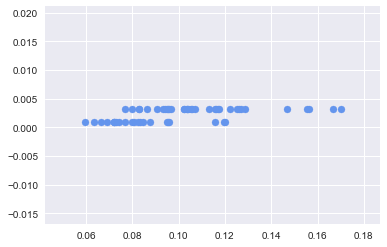

In [157]:
plt.figure()
#plt.scatter(new_x, new_y, c='darkorange')
plt.scatter(x_test_new.HI_ratio, reg_y1, color='cornflowerblue')
#plt.plot(x_test_std, reg_y2, color='yellowgreen')

In [158]:
reg2.score(x_test_new, y_test_new)

0.61628910657607694

In [159]:
reg2.score(x_train_new, y_train_new)

0.93723190340618301

In [160]:
DT_features = reg2.feature_importances_

In [100]:
from sklearn.ensemble import RandomForestRegressor

In [126]:
RF_test_sc = []
RF_train_sc = []

for n in range(1,21):
    RF_reg = RandomForestRegressor(max_depth=n)

    train = RF_reg.fit(x_train_new, y_train_new).score(x_train_new, y_train_new)
    RF_train_sc.append(train)
    
    test = RF_reg.fit(x_test_new, y_test_new).score(x_test_new, y_test_new)
    RF_test_sc.append(test)
    

/Users/allandong/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


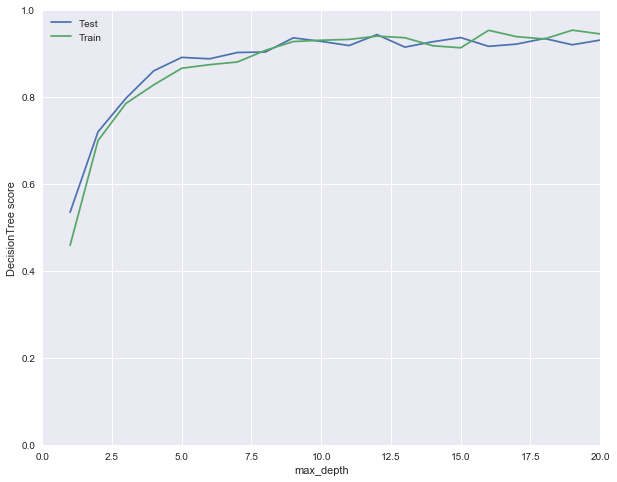

In [132]:
plt.figure(figsize=(10,8))
plt.ylim(0,1)
plt.xlim(0,20)
plt.legend()

plt.plot(range(1,21), RF_test_sc, label='Test')
plt.plot(range(1,21), RF_train_sc, label='Train')

plt.legend()
plt.xlabel('max_depth')
plt.ylabel('DecisionTree score')
plt.show()

In [142]:
RF_reg1 = RandomForestRegressor(max_depth=2)
RF_reg2 = RandomForestRegressor(max_depth=10)

RF_reg1.fit(x_train_new, y_train_new)
RF_reg2.fit(x_train_new, y_train_new)



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [143]:
RF_reg2.score(x_test_new, y_test_new)

0.71527851112102669

In [144]:
RF_reg2.score(x_train_new, y_train_new)

0.92810358800186543

In [146]:
RF_features = RF_reg2.feature_importances_

In [155]:
RF_features.shape

(48,)

In [149]:
x_train_columns = np.array(x_train_new.columns)

In [156]:
x_train_columns.shape

(48,)

In [164]:
df_feat = pd.DataFrame([DT_features, RF_features], columns = x_train_new.columns, index=['DecisionTree', 'RandomForest']).T

In [166]:
df_feat['DecisionTree'].reindex(df_feat['DecisionTree'].sort_values(inplace=False, ascending=False).index)

Race[T.White]                            0.428472
County[T.Caddo Parish, LA]               0.299904
County[T.Mobile County, AL]              0.057862
County[T.Philadelphia County, PA]        0.028271
County[T.St. Louis city, MO]             0.027241
HI_ratio                                 0.026270
County[T.East Baton Rouge Parish, LA]    0.022341
Gender[T.Male]                           0.017114
County[T.Jefferson County, AL]           0.013439
County[T.Los Angeles County, CA]         0.012408
County[T.Worcester County, MA]           0.011707
County[T.Harris County, TX]              0.010170
County[T.Cuyahoga County, OH]            0.007689
Year                                     0.005655
County[T.Baltimore city, MD]             0.005097
County[T.Oklahoma County, OK]            0.005042
County[T.Milwaukee County, WI]           0.004954
unemployment_rate                        0.004258
County[T.Will County, IL]                0.003534
County[T.Marion County, IN]              0.003083


In [167]:
df_feat['RandomForest'].reindex(df_feat['RandomForest'].sort_values(inplace=False, ascending=False).index)

County[T.Caddo Parish, LA]               0.402274
Race[T.White]                            0.335143
County[T.Mobile County, AL]              0.039379
unemployment_rate                        0.029814
County[T.East Baton Rouge Parish, LA]    0.025148
County[T.St. Louis city, MO]             0.022283
County[T.Philadelphia County, PA]        0.020892
HI_ratio                                 0.018888
County[T.Worcester County, MA]           0.015511
Gender[T.Male]                           0.011394
County[T.Jefferson County, AL]           0.010680
Year                                     0.009986
County[T.Milwaukee County, WI]           0.008149
County[T.Kings County, NY]               0.006854
County[T.Oklahoma County, OK]            0.006681
County[T.Baltimore city, MD]             0.006494
County[T.Hamilton County, OH]            0.005870
County[T.Cuyahoga County, OH]            0.004939
County[T.Dallas County, TX]              0.004436
County[T.Harris County, TX]              0.003807


In [ ]:
pca_df['PCA-1'].reindex(pca_df['PCA-1'].abs().sort_values(inplace=False, ascending=False).index)